In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [3]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [4]:
from gradient_solver import construct_distance_matrix

In [5]:
import timeit

In [6]:
from IPython.display import display, Math, Latex

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [8]:
from scipy.spatial.distance import correlation

In [9]:
from gradient_solver import *

In [10]:
'''df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

# Ensure that both datasets contain the same indices
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]'''

'df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()\ndf_observable_distances: pd.DataFrame = pd.read_excel(\n    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",\n    index_col=0\n)\nfeatures: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())\n\n# Ensure that both datasets contain the same indices\nvalid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)\ndf_explainable = df_explainable.loc[valid_indices]\ndf_observable_distances = df_observable_distances.loc[valid_indices]'

In [11]:
##################
# Synthetic Data #
##################
individuals = 100
base_size = 10000

#observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
'''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
df_explainable = pd.DataFrame(explanation_data)
df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
df_explainable.set_index('Individual', inplace=True)'''

df_explainable = pd.DataFrame({
    'Age': np.random.choice([0., 0.5, 1.], individuals),
    'Weight': np.random.uniform(0,1, size=individuals),
    'Is_a_Zebra': np.random.choice([0., 1.], individuals),
    'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
    'Noise_1': np.random.uniform(0,1, size=individuals),
    'Noise_2': np.random.uniform(0,1, size=individuals),
    'Noise_3': np.random.uniform(0,1, size=individuals),
    'Noise_4': np.random.uniform(0,1, size=individuals),
    'Noise_5': np.random.uniform(0,1, size=individuals),
    'Individual': [f'Individual_{n}' for n in range(individuals)]
})
df_explainable.set_index('Individual', inplace=True)

explaining_features = np.array(list(df_explainable.columns))
individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

df_observable = pd.DataFrame({
    'Individual': individual_array,
})
df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.65) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.65) * np.random.uniform(0,1, size=base_size)
df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

df_observable.set_index('Individual', inplace=True)
observed_features = list(df_observable.columns)

df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [12]:
df_explainable = pd.read_csv('../tst/df.csv').rename(columns={'Unnamed: 0': 'Datum'})

In [13]:
df_observable = pd.read_csv('../tst/bf.csv')

In [14]:
index_name = 'Datum'
observed_features = []
for col in df_observable:
    if col != index_name:
        observed_features.append(col)

explaining_features = []
for col in df_explainable:
    if col != index_name:
        explaining_features.append(col)


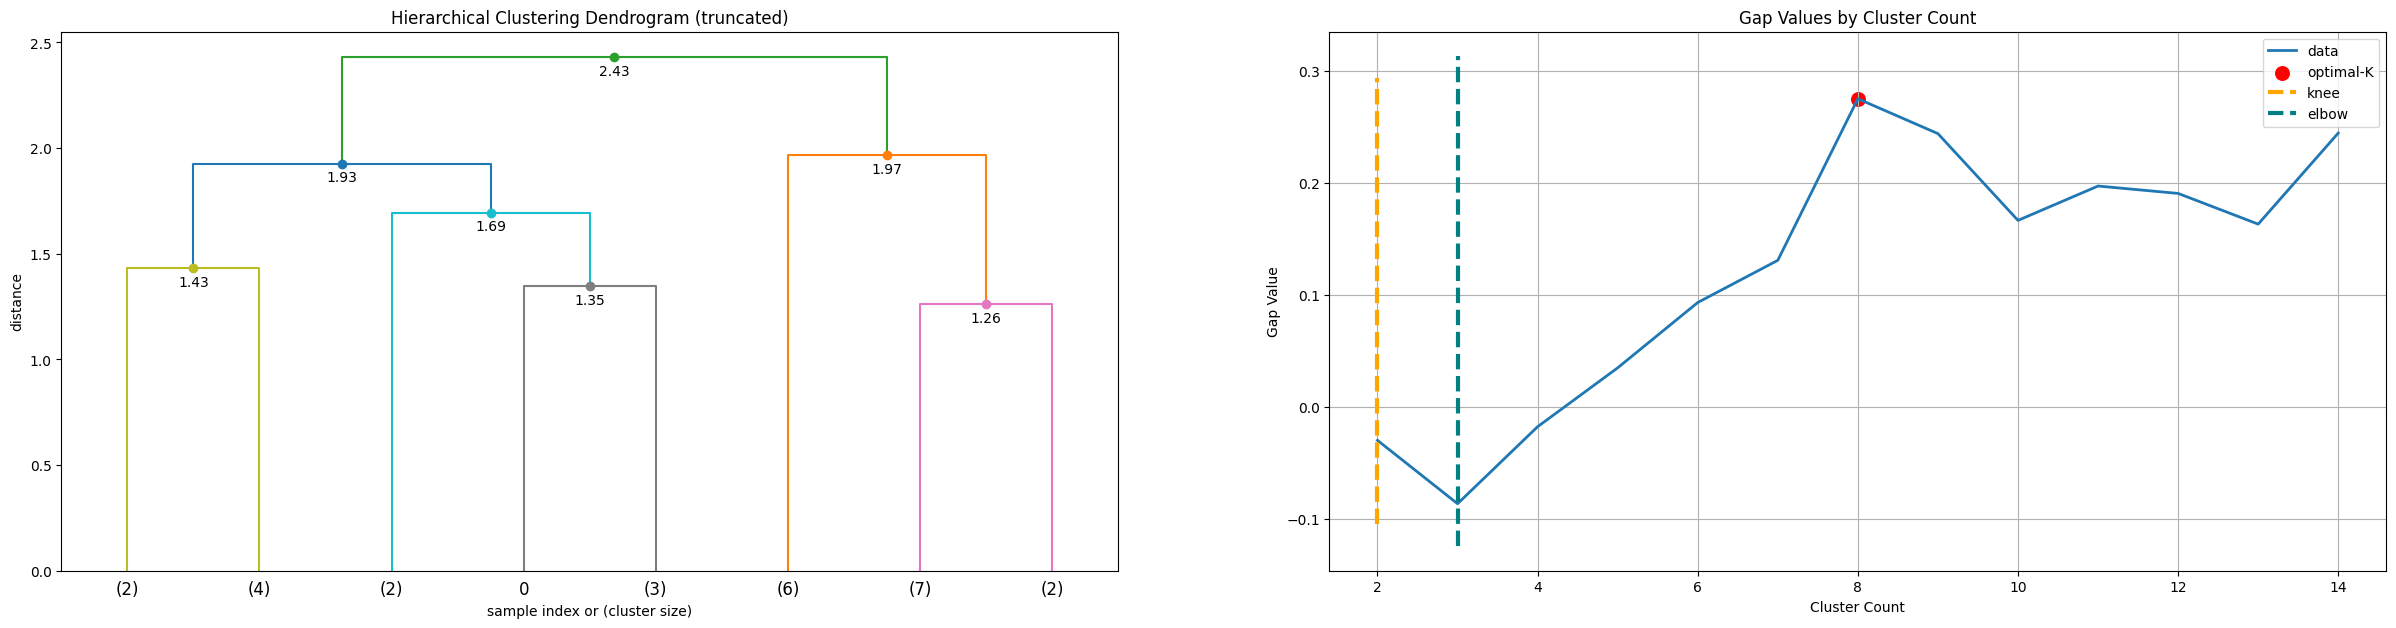

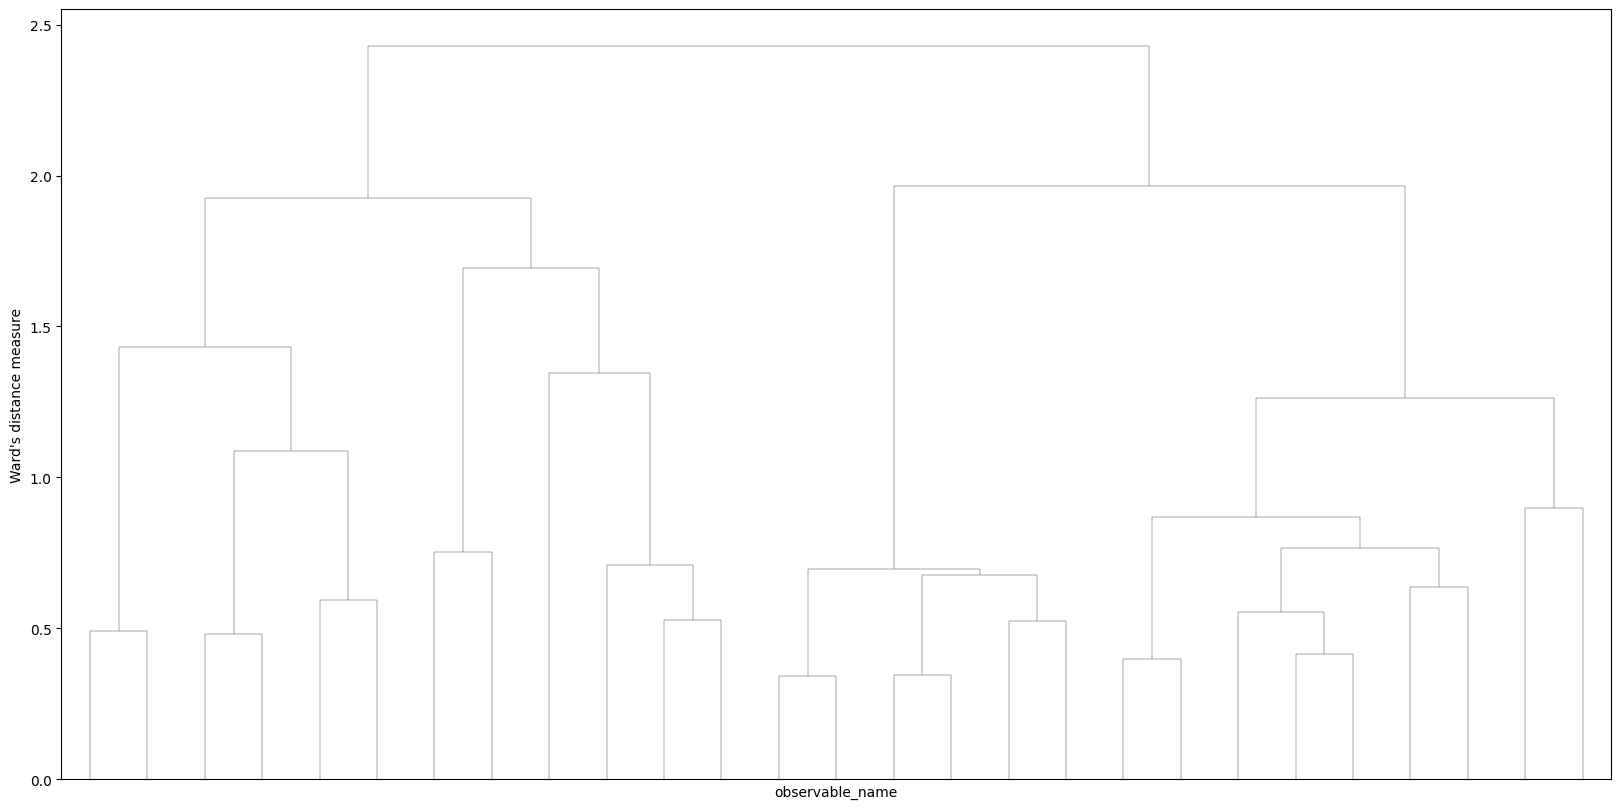

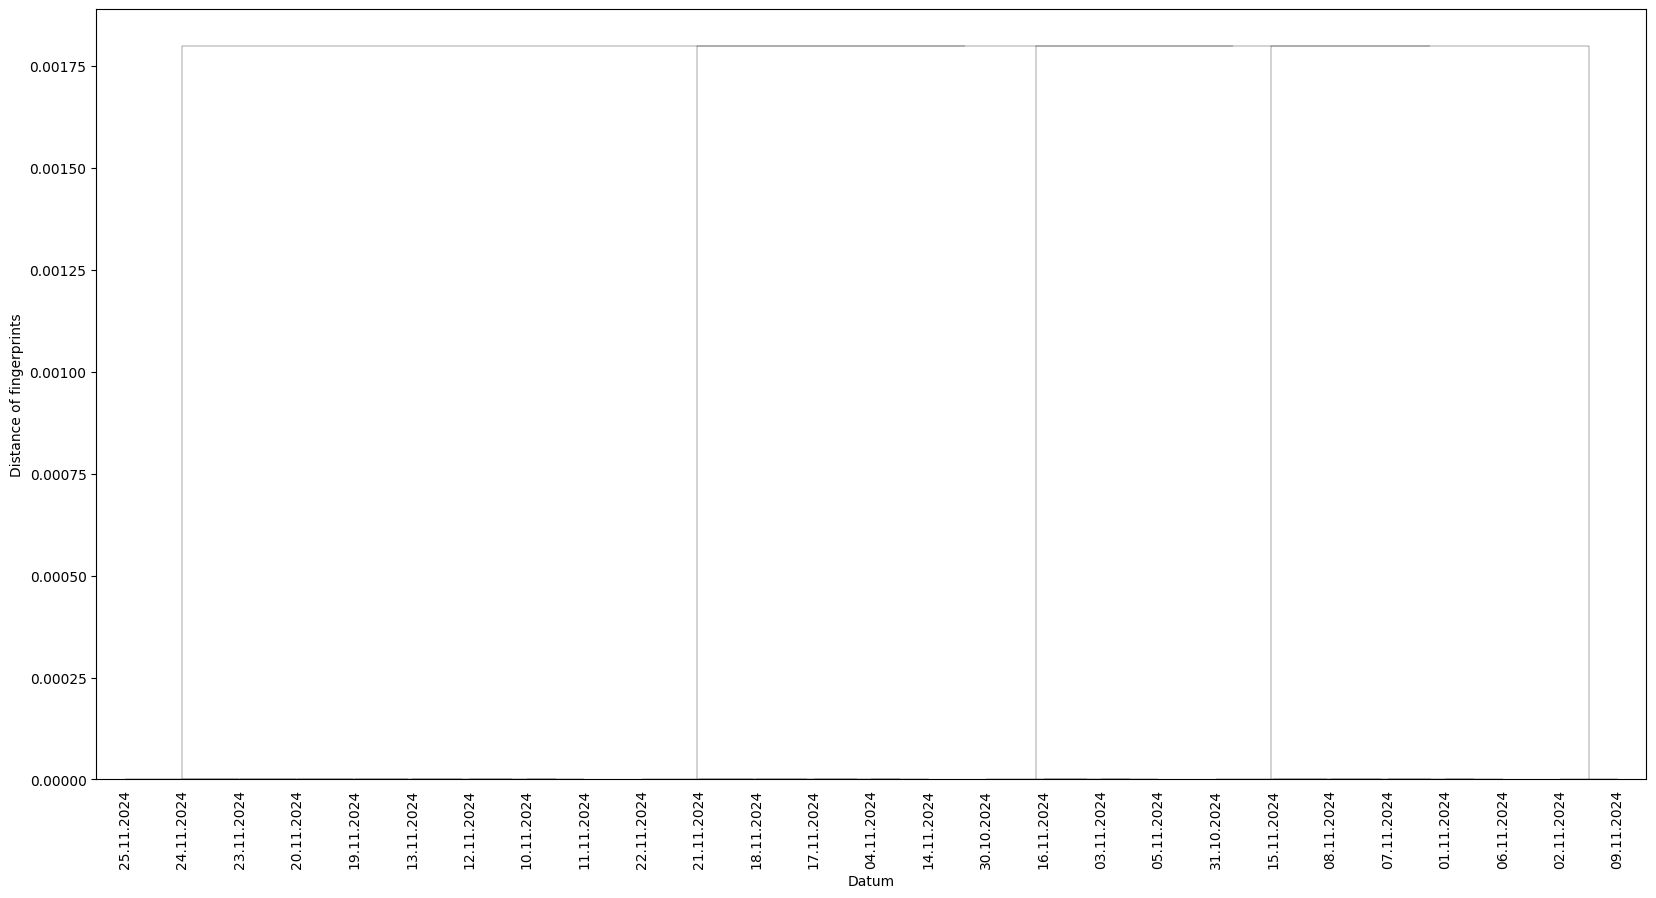

In [21]:
#index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.01,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters= 5, #optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [22]:
observable_patterns_result['spider_plots']

In [26]:
e = preparation_result['explainable_df'].copy()

In [52]:
a = preparation_result['explainable_df'].copy().loc[:, q].apply(lambda x: np.nan_to_num(x)).set_index(index_name)

In [53]:
b = observable_patterns_result['pw_norm_dist'].copy()

In [54]:
valid_indices = np.intersect1d(a.index, b.index)
valid_indices.sort()

In [ ]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy().loc[:, q].apply(lambda x: np.nan_to_num(x)).set_index(index_name).loc[valid_indices],
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy().loc[valid_indices, :].loc[:, valid_indices],
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [ ]:
calculate_explainable_distances_result['overview_df']

In [ ]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [ ]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

In [ ]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [ ]:
my_df.loc[:, [index_name] + observed_features]

In [ ]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

In [ ]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [ ]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [ ]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

In [ ]:
@torch.jit.script
def new_torch_matrix_jensenshannon(A:torch.Tensor) -> torch.Tensor:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clamp(min = 1e-20)
    normalized_A = clamped_A / torch.sum(clamped_A, dim=1).unsqueeze(-1)
    m_A = (normalized_A.unsqueeze(-1) + normalized_A.T).permute(2,0,1) / 2.0
    relative_entropies = torch_relative_entropy(normalized_A, m_A) + 1e-10
    js = (relative_entropies.sum(dim = 2) + relative_entropies.sum(dim = 2).T).clamp(min = 0.)
    return (js / 2.0).sqrt()

In [1614]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, num_virtual_features:int, index_name:str, num_samples:int=1, power:int=4, penalty=0., device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20, max=1.)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=1e-20)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power

        self.feature_names = list(self.df_explainable.columns)
        self.num_features = len(self.feature_names)

        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples

        ###
        self.virtual_features = []
        self.num_virtual_features = num_virtual_features
        for v_i in range(self.num_virtual_features):

            epsilon = 1e-4

            init_param = torch.zeros([len(self.feature_names)]) + epsilon
            a_weights  = torch.zeros([len(self.feature_names)]) + epsilon
            ##a_weights[v_i] = 1. - epsilon
            #a_weights[2] = 1. - epsilon
            c_weights = torch.zeros([len(self.feature_names)]) + epsilon
            
            Q = 1.
            self.add_param(f'antecedens_positions_{v_i}', init_param.logit() / Q , lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_positions_{v_i}', init_param.logit() / Q,  lambda x: (x * Q).sigmoid())
            self.add_param(f'antecedens_weights_{v_i}', a_weights.logit() / Q, lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_weights_{v_i}', c_weights.logit() / Q, lambda x: (x * Q).sigmoid())

            self.add_param(f'antecedens_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())
            self.add_param(f'consequent_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())

            self.virtual_features.append(v_i)
        ###
        
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names) + self.num_virtual_features, value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        self.feature_names = np.array(self.feature_names)

        self.U = lambda shape: Uniform(0, 1).sample(shape)

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

    def try_interpretation(self, v_i, thresh):
        if type(v_i) == int:
            return self.interpretation(v_i, thresh)
        else:
            return v_i

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)
        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise
        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):
        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)
        self.add_param(param_name, init_value, lambda x: x.sigmoid())

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self, thresh=0.05):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        f = {self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))}
        for v_i in self.virtual_features:
            interpretation = self.interpretation(v_i, thresh=thresh)
            feature_weight = feature_weights[:, v_i + len(self.feature_names)]
            f[interpretation] = feature_weight

        feature_weight_df = pd.DataFrame(f)
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, inv_observation_weights, cluster_positions):
        epsilon = 1e-20
        _dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * inv_observation_weights).sum(2).sqrt()
        norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
        masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
        accumulated_norm_dist = masked_norm_dist.sum(dim=0)
        fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
        #pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power)
        #sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
        #return sampled_fingerprints
        return fingerprint_distances
    
    def __conditional(self, v_i):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')

        antecedens = (self.tensor_explainable - antecedens_positions).abs().pow(antecedens_weights).prod(dim=1)
        consequent = (self.tensor_explainable - consequent_positions).abs().pow(consequent_weights).prod(dim=1)

        return antecedens, consequent
    
    def conditional(self, v_i):
        M = 10.
        epsilon = 1e-7

        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')
        antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}')
        consequent_threshold = self.constrained(f'consequent_threshold_{v_i}')

        antecedens_dist = (self.tensor_explainable - antecedens_positions).abs()
        antecedens_sigmoid = ((antecedens_dist - antecedens_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        antecedens = (antecedens_sigmoid * antecedens_dist).pow(antecedens_weights).prod(dim=1)
        antecedens = (antecedens_dist).pow(antecedens_weights).prod(dim=1)

        antecedens = (antecedens - antecedens.min()) / (antecedens.max() - antecedens.min())

        consequent_dist = (self.tensor_explainable - consequent_positions).abs()
        consequent_sigmoid = ((consequent_dist - consequent_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        consequent = (consequent_sigmoid * consequent_dist).pow(consequent_weights).prod(dim=1)

        return antecedens, consequent 
    
    def interpretation(self, v_i, thresh = 0.05):
            antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
            consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
            antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
            consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()
            antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}').clone().detach().numpy()
            consequent_threshold = self.constrained(f'consequent_threshold_{v_i}').clone().detach().numpy()

            antecedens_weights = antecedens_weights/antecedens_weights.sum()
            consequent_weights = consequent_weights/consequent_weights.sum()

            antecedens_string = self.logic_string_helper(antecedens_weights, antecedens_positions, antecedens_threshold, thresh)
            consequent_string = self.logic_string_helper(consequent_weights, consequent_positions, consequent_threshold, thresh)
            interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

            return interpretation_string
    
    def logic_string_helper(self, _weights, positions, thresholds, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _threshold = thresholds[_features_indices]
            _string = ''
            i = 0
            for symbol, pos, thr in zip(_features, _position, _threshold):
                if pos < 0.5:
                    addendum1 = f''
                    addendum2 = f' > {thr:.2f}'
                else:
                    addendum1 = f'(1-'
                    addendum2 = f') < {thr:.2f}'
                if i == len(_features) - 1:
                    _string += f'[{addendum1}{symbol}{addendum2}]'
                else:
                    _string += f'[{addendum1}{symbol}{addendum2}] ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string
    
    def ___logic_string_helper(self, _weights, positions, threshold, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _string = ''
            i = 0
            for symbol, pos in zip(_features, _position):
                if pos < 0.5:
                    addendum = 'Higher('
                else:
                    addendum = 'Lower('
                if i == len(_features) - 1:
                    _string += f'{addendum}{symbol})'
                else:
                    _string += f'{addendum}{symbol}) ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string

    def loss(self, data:torch.Tensor|None=None) -> torch.tensor:

        # feature_weights
        feature_weights = self.constrained('feature_weights')

        # observation_weights
        observation_weights = self.constrained('observation_weights')
        #inv_observation_weights = 1.00 + 1e-6 - observation_weights

        # cluster positions
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

        # fingerprints
        sampled_fingerprints = self.sample_fingerprints(observation_weights, cluster_positions)

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

        # Construct the distance matrix for the features
        feature_weights = (feature_weights / feature_weights.sum())
        feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0],1)
        explainables = self.tensor_explainable.clone()
        aux_loss = 0.
        for v_i in range(self.num_virtual_features):
            antecedens, consequent = self.conditional(v_i)
            feature_weights[:, self.num_features + v_i] *= antecedens
            explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))
            
        feature_distances = construct_distance_matrix(
            A=explainables, feature_weights=feature_weights, normalize=False
        )

        # Calculate the correlation between the distance matrix and the observable distances
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)

        #k_penalty = (feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef #+ k_penalty

        self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [1621]:
self = model

In [1622]:
explainables = model.tensor_explainable.clone()
explainables.shape

torch.Size([100, 9])

In [1623]:
feature_weights = self.constrained('feature_weights')
feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0],1)

In [1624]:
for v_i in range(model.num_virtual_features):
    antecedens, consequent = model.conditional(v_i)
    feature_weights[:, self.num_features + v_i] *= antecedens
    explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))
    print(explainables.shape)

torch.Size([100, 10])


In [1625]:
antecedens

tensor([0.9511, 0.9286, 0.9994, 0.9754, 0.9599, 0.9737, 0.9760, 0.9831, 0.9894,
        0.9201, 0.9378, 0.9664, 1.0000, 0.9900, 0.9943, 0.9494, 0.9961, 0.9488,
        0.9920, 0.9881, 0.9794, 0.9924, 0.9676, 0.9904, 0.9747, 0.9985, 0.9948,
        0.9585, 0.9951, 0.9788, 0.9962, 0.9496, 0.9974, 0.9332, 0.9447, 0.9348,
        0.9924, 0.9960, 0.9757, 0.9962, 0.9596, 0.9995, 0.9663, 0.0000, 0.9291,
        0.9912, 0.9916, 0.9414, 0.9897, 0.9902, 0.9544, 0.9923, 0.9520, 0.9957,
        0.9488, 0.9995, 0.9747, 0.9552, 0.9805, 0.9707, 0.9928, 0.9633, 0.9879,
        0.9232, 0.9966, 0.9894, 0.9604, 0.9772, 0.9984, 0.9906, 0.9999, 0.9977,
        0.9865, 0.9779, 0.9957, 0.9752, 0.9668, 0.9915, 0.9753, 0.9304, 0.9837,
        0.9881, 0.9555, 0.9349, 0.9787, 0.9790, 0.9934, 0.9465, 0.9870, 1.0000,
        0.9824, 0.9827, 0.9791, 0.9595, 0.9981, 0.9851, 0.9847, 0.9350, 0.9676,
        0.9922], dtype=torch.float64, grad_fn=<DivBackward0>)

In [1626]:
model.best_feature_weights[:3, :]

tensor([[1.8350e-01, 2.5210e-11, 2.7056e-04, 2.4170e-11, 1.9470e-10, 1.3044e-11,
         3.5582e-11, 4.5233e-11, 1.5581e-11, 7.7581e-01],
        [1.8350e-01, 2.5210e-11, 2.7056e-04, 2.4170e-11, 1.9470e-10, 1.3044e-11,
         3.5582e-11, 4.5233e-11, 1.5581e-11, 7.5729e-01],
        [1.8350e-01, 2.5210e-11, 2.7056e-04, 2.4170e-11, 1.9470e-10, 1.3044e-11,
         3.5582e-11, 4.5233e-11, 1.5581e-11, 8.1576e-01]], dtype=torch.float64)

In [1627]:
feature_weights = (feature_weights / feature_weights.unsqueeze(-1).sum(dim=1))

In [1628]:
feature_weights[:3, :-5]

tensor([[1.9056e-01, 2.5417e-11, 2.6088e-04, 2.4369e-11, 1.9645e-10],
        [1.9428e-01, 2.5913e-11, 2.6597e-04, 2.4845e-11, 2.0028e-10],
        [1.8303e-01, 2.4413e-11, 2.5057e-04, 2.3406e-11, 1.8869e-10]],
       dtype=torch.float64, grad_fn=<SliceBackward0>)

In [1629]:
...

Ellipsis

In [1630]:
feature_distances = construct_distance_matrix(
    A=explainables, feature_weights=model.best_feature_weights, normalize=False
)


In [1631]:
observation_weights / observation_weights.sum()

tensor([1., 0.])

In [1634]:
# observation_weights
observation_weights = self.constrained('observation_weights')
inv_observation_weights = 1.00 + 1e-6 - observation_weights

# cluster positions
cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)

# fingerprints
sampled_fingerprints = self.sample_fingerprints(observation_weights, cluster_positions)
fingerprint_distances = new_torch_matrix_jensenshannon(sampled_fingerprints)

In [1635]:
sampled_fingerprints = sampled_fingerprints.clone().detach().numpy()

In [1636]:
((df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy()[0] - df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy())).round(2) #> 0.1

array([ 0.  ,  0.5 , -0.01,  0.02, -0.5 , -0.  ,  0.5 ,  0.5 , -0.5 ,
       -0.5 ,  0.02,  0.07, -0.5 ,  0.02, -0.06, -0.5 ,  0.5 ,  0.5 ,
        0.04,  0.  ,  0.5 , -0.05, -0.03,  0.  , -0.5 , -0.  , -0.5 ,
        0.02,  0.5 ,  0.  , -0.  ,  0.  , -0.5 ,  0.01,  0.  ,  0.01,
        0.5 , -0.5 , -0.  , -0.5 ,  0.03,  0.5 ,  0.5 , -0.5 , -0.5 ,
       -0.02, -0.04, -0.  , -0.5 ,  0.  ,  0.01,  0.5 , -0.5 , -0.5 ,
        0.  ,  0.01, -0.5 ,  0.02, -0.  , -0.5 ,  0.5 , -0.  ,  0.5 ,
        0.01, -0.5 , -0.  ,  0.5 ,  0.  ,  0.5 , -0.  ,  0.5 ,  0.04,
        0.  , -0.05, -0.  , -0.04,  0.03,  0.  ,  0.  ,  0.5 ,  0.03,
       -0.5 , -0.5 ,  0.5 ,  0.5 , -0.  , -0.04,  0.01, -0.  ,  0.5 ,
        0.  , -0.  , -0.5 , -0.  , -0.01,  0.02, -0.5 ,  0.05,  0.5 ,
        0.5 ])

In [1658]:
cluster_positions[:, 0]

tensor([0.0514, 0.0007, 0.0181, 0.0181, 0.0192, 0.0181, 0.0512, 0.0007, 0.0013,
        0.0519, 0.0013, 0.0007, 0.0007, 0.0007], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1659]:
cluster_positions[:, 1]

tensor([0.9612, 0.2097, 0.2521, 0.2450, 0.9943, 0.0105, 0.9689, 0.2111, 0.9880,
        0.9605, 0.9950, 0.2526, 0.2089, 0.2135], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [ ]:
sampled_fingerprints[0, :] # 0.5

array([0.06629946, 0.07379785, 0.07122275, 0.07122986, 0.07106893,
       0.07122711, 0.06633995, 0.07379785, 0.07370029, 0.06622668,
       0.07370043, 0.07379363, 0.07379778, 0.07379744])

In [ ]:
sampled_fingerprints[1, :] # 0

array([0.22122631, 0.00283974, 0.07677577, 0.07656756, 0.0813082 ,
       0.07666505, 0.22003888, 0.00283797, 0.00492314, 0.22336164,
       0.00493156, 0.0028423 , 0.00284183, 0.00284005])

In [ ]:
sampled_fingerprints[4, :] # 1

array([0.06890642, 0.07259363, 0.07132736, 0.07133086, 0.07125172,
       0.0713295 , 0.06892632, 0.07259362, 0.07254565, 0.06887063,
       0.07254572, 0.07259155, 0.07259359, 0.07259342])

In [1652]:
jensenshannon(sampled_fingerprints[0, :], sampled_fingerprints[1, :])

np.float64(0.4528988508539224)

In [1653]:
jensenshannon(sampled_fingerprints[0, :], sampled_fingerprints[4, :])

np.float64(0.007410359379483984)

In [1378]:
(fingerprint_distances[0].clone().detach().numpy() * 1.).round(3) #> 0.05

array([0.   , 0.789, 0.105, 0.099, 0.106, 0.012, 0.777, 0.788, 0.109,
       0.107, 0.121, 0.135, 0.108, 0.114, 0.05 , 0.106, 0.796, 0.778,
       0.116, 0.098, 0.778, 0.068, 0.086, 0.056, 0.109, 0.013, 0.105,
       0.093, 0.781, 0.08 , 0.015, 0.005, 0.106, 0.082, 0.032, 0.097,
       0.784, 0.107, 0.025, 0.112, 0.121, 0.786, 0.782, 0.107, 0.11 ,
       0.075, 0.07 , 0.074, 0.11 , 0.008, 0.088, 0.773, 0.107, 0.107,
       0.011, 0.081, 0.107, 0.097, 0.069, 0.109, 0.783, 0.03 , 0.782,
       0.091, 0.108, 0.011, 0.78 , 0.02 , 0.787, 0.011, 0.787, 0.127,
       0.005, 0.059, 0.027, 0.081, 0.124, 0.011, 0.097, 0.782, 0.114,
       0.108, 0.106, 0.783, 0.787, 0.011, 0.062, 0.12 , 0.014, 0.783,
       0.015, 0.036, 0.107, 0.019, 0.086, 0.092, 0.109, 0.12 , 0.777,
       0.784])

In [1461]:
epsilon = 1e-20
_dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()
norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
accumulated_norm_dist = masked_norm_dist.sum(dim=0)
fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power)
sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)
sampled_fingerprints[0]

tensor([0.1573, 0.0023, 0.1012, 0.1322, 0.1328, 0.0755, 0.0998, 0.0037, 0.0935,
        0.0954, 0.0998, 0.0023, 0.0019, 0.0023], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1687]:
(self.tensor_observable.unsqueeze(1)[0, :, 0] - cluster_positions.unsqueeze(0)[:,:, 0]).pow(2).clamp(min=epsilon)#[0]

tensor([[0.2001, 0.2480, 0.2310, 0.2310, 0.2300, 0.2310, 0.2003, 0.2480, 0.2474,
         0.1996, 0.2474, 0.2480, 0.2480, 0.2480]], dtype=torch.float64,
       grad_fn=<ClampBackward1>)

In [1700]:
(self.tensor_observable.unsqueeze(1)[0, :, 0] - cluster_positions.unsqueeze(0)[:,:, 0]).pow(2)

tensor([[0.2001, 0.2480, 0.2310, 0.2310, 0.2300, 0.2310, 0.2003, 0.2480, 0.2474,
         0.1996, 0.2474, 0.2480, 0.2480, 0.2480]], dtype=torch.float64,
       grad_fn=<PowBackward0>)

In [1699]:
(self.tensor_observable.unsqueeze(1)[110, :, 0] - cluster_positions.unsqueeze(0)[:,:, 0]).pow(2)

tensor([[2.5015e-03, 5.1851e-07, 2.7900e-04, 2.7740e-04, 3.1486e-04, 2.7802e-04,
         2.4742e-03, 5.1843e-07, 3.5814e-09, 2.5510e-03, 3.6985e-09, 4.7822e-07,
         5.1780e-07, 5.1445e-07]], dtype=torch.float64, grad_fn=<PowBackward0>)

In [1701]:
(self.tensor_observable.unsqueeze(1)[405, :, 0] - cluster_positions.unsqueeze(0)[:,:, 0]).pow(2)

tensor([[0.8998, 0.9986, 0.9641, 0.9642, 0.9621, 0.9642, 0.9003, 0.9986, 0.9973,
         0.8989, 0.9973, 0.9986, 0.9986, 0.9986]], dtype=torch.float64,
       grad_fn=<PowBackward0>)

In [1678]:
self.tensor_observable.unsqueeze(1)[0, :, 0]

tensor([0.4987], dtype=torch.float64)

In [1667]:
observation_weights

tensor([9.7108e-01, 7.7542e-07], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)

In [1671]:
cluster_positions.unsqueeze(0)[:, 0]

tensor([[0.0514, 0.9612]], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [1664]:
self.tensor_observable.unsqueeze(1)[0]

tensor([[0.4987, 0.6806]], dtype=torch.float64)

In [1734]:
cluster_positions.unsqueeze(0)[0, :, 0]

tensor([0.0514, 0.0007, 0.0181, 0.0181, 0.0192, 0.0181, 0.0512, 0.0007, 0.0013,
        0.0519, 0.0013, 0.0007, 0.0007, 0.0007], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1450]:
sampled_fingerprints[1]

tensor([0.0710, 0.0129, 0.0631, 0.0659, 0.0623, 0.0441, 0.0594, 0.4150, 0.0552,
        0.0589, 0.0549, 0.0129, 0.0115, 0.0129], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1380]:
observation_weights

tensor([0.9233, 0.3743], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [1702]:
(self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon)[0] * observation_weights

tensor([[1.9429e-01, 6.1050e-08],
        [2.4087e-01, 1.7196e-07],
        [2.2431e-01, 1.4238e-07],
        [2.2435e-01, 1.4714e-07],
        [2.2334e-01, 7.6300e-08],
        [2.2434e-01, 3.4819e-07],
        [1.9453e-01, 6.4464e-08],
        [2.4087e-01, 1.7094e-07],
        [2.4023e-01, 7.3259e-08],
        [1.9386e-01, 6.0742e-08],
        [2.4023e-01, 7.6666e-08],
        [2.4084e-01, 1.4204e-07],
        [2.4087e-01, 1.7258e-07],
        [2.4086e-01, 1.6921e-07]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [1739]:
_d0 = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()[0]
_d0

tensor([0.4473, 0.4980, 0.4806, 0.4807, 0.4796, 0.4806, 0.4476, 0.4980, 0.4974,
        0.4468, 0.4974, 0.4980, 0.4980, 0.4980], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1740]:
_d1 = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()[110]
_d1

tensor([5.0015e-02, 7.2008e-04, 1.6703e-02, 1.6655e-02, 1.7744e-02, 1.6674e-02,
        4.9741e-02, 7.2002e-04, 5.9845e-05, 5.0507e-02, 6.0815e-05, 6.9154e-04,
        7.1958e-04, 7.1725e-04], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1713]:
_d4 = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(1).clamp(min=epsilon) * observation_weights).sum(2).sqrt()[405]
_d4

tensor([0.9598, 0.9851, 0.9765, 0.9765, 0.9760, 0.9765, 0.9599, 0.9851, 0.9848,
        0.9595, 0.9848, 0.9851, 0.9851, 0.9851], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1714]:
observation_weights = torch.tensor([1., 0.])

In [1715]:
epsilon = 1e-20
_dist = ((self.tensor_observable.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()
norm_dist = (_dist / _dist.sum(dim=1).unsqueeze(-1))
masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
accumulated_norm_dist = masked_norm_dist.sum(dim=0)
fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power)
sampled_fingerprints = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0).clone().detach().numpy()

In [1741]:
cluster_positions

tensor([[5.1425e-02, 9.6120e-01],
        [6.8949e-04, 2.0970e-01],
        [1.8113e-02, 2.5210e-01],
        [1.8065e-02, 2.4501e-01],
        [1.9154e-02, 9.9430e-01],
        [1.8084e-02, 1.0518e-02],
        [5.1151e-02, 9.6894e-01],
        [6.8955e-04, 2.1109e-01],
        [1.3497e-03, 9.8798e-01],
        [5.1917e-02, 9.6049e-01],
        [1.3488e-03, 9.9505e-01],
        [7.1803e-04, 2.5261e-01],
        [6.8998e-04, 2.0885e-01],
        [6.9231e-04, 2.1347e-01]], dtype=torch.float64,
       grad_fn=<ClampBackward1>)

In [1742]:
self.mask_tensor.argmax(dim=0)

tensor([   0,  110,  214,  320,  405,  508,  603,  702,  793,  888, 1001, 1100,
        1198, 1301, 1404, 1513, 1601, 1700, 1807, 1908, 2007, 2103, 2198, 2300,
        2417, 2512, 2604, 2688, 2776, 2880, 2974, 3075, 3171, 3281, 3392, 3504,
        3634, 3733, 3844, 3943, 4040, 4136, 4236, 4321, 4427, 4522, 4630, 4719,
        4819, 4924, 5038, 5144, 5241, 5336, 5437, 5514, 5606, 5715, 5808, 5920,
        6025, 6117, 6209, 6316, 6418, 6543, 6655, 6761, 6860, 6934, 7045, 7124,
        7214, 7313, 7427, 7522, 7602, 7707, 7794, 7890, 7999, 8102, 8215, 8313,
        8410, 8497, 8619, 8712, 8809, 8912, 9023, 9123, 9224, 9318, 9407, 9491,
        9597, 9704, 9793, 9902])

In [1743]:
self.mask_tensor[110, :]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [1747]:
norm_dist[0]  # 0.4987

tensor([0.0663, 0.0738, 0.0712, 0.0712, 0.0711, 0.0712, 0.0663, 0.0738, 0.0737,
        0.0662, 0.0737, 0.0738, 0.0738, 0.0738], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1748]:
norm_dist[110] # 0.0014

tensor([0.2256, 0.0032, 0.0753, 0.0751, 0.0800, 0.0752, 0.2243, 0.0032, 0.0003,
        0.2278, 0.0003, 0.0031, 0.0032, 0.0032], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1749]:
norm_dist[405] # 1.000

tensor([0.0689, 0.0726, 0.0713, 0.0713, 0.0713, 0.0713, 0.0689, 0.0726, 0.0725,
        0.0689, 0.0725, 0.0726, 0.0726, 0.0726], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1753]:
_dist[0]

tensor([0.4473, 0.4980, 0.4806, 0.4807, 0.4796, 0.4806, 0.4476, 0.4980, 0.4974,
        0.4468, 0.4974, 0.4980, 0.4980, 0.4980], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1755]:
_dist[110]

tensor([5.0015e-02, 7.2008e-04, 1.6703e-02, 1.6655e-02, 1.7744e-02, 1.6674e-02,
        4.9741e-02, 7.2002e-04, 5.9845e-05, 5.0507e-02, 6.0815e-05, 6.9154e-04,
        7.1958e-04, 7.1725e-04], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

<Axes: >

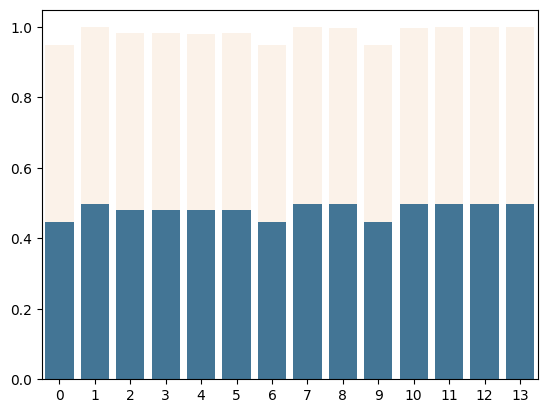

In [1765]:
sns.barplot(_dist[0].clone().detach().numpy())
sns.barplot(_dist[405].clone().detach().numpy(), alpha = 0.1)

<Axes: >

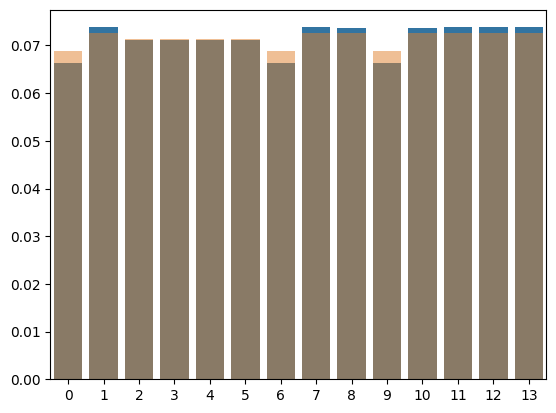

In [1767]:
sns.barplot(norm_dist[0].clone().detach().numpy())
sns.barplot(norm_dist[405].clone().detach().numpy(), alpha = 0.5)

In [1752]:
_dist[405]

tensor([0.9486, 0.9993, 0.9819, 0.9819, 0.9808, 0.9819, 0.9488, 0.9993, 0.9987,
        0.9481, 0.9987, 0.9993, 0.9993, 0.9993], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1726]:
jensenshannon(norm_dist[0].clone().detach().numpy(), norm_dist[110].clone().detach().numpy())

np.float64(0.4678293216996616)

In [1727]:
jensenshannon(norm_dist[0].clone().detach().numpy(), norm_dist[405].clone().detach().numpy())

np.float64(0.007452810725911993)

In [1728]:
accumulated_norm_dist[0]

tensor([7.2929, 8.1178, 7.8345, 7.8353, 7.8176, 7.8350, 7.2974, 8.1178, 8.1070,
        7.2849, 8.1070, 8.1173, 8.1178, 8.1177], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1606]:
accumulated_norm_dist[1]

tensor([1.1124e+01, 7.1281e-03, 1.1775e+01, 1.1281e+01, 1.1359e+01, 1.1562e+01,
        1.1772e+01, 7.1284e-03, 1.1814e+01, 1.1837e+01, 1.1441e+01, 7.1283e-03,
        7.1280e-03, 7.1279e-03], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1607]:
accumulated_norm_dist[4]

tensor([ 4.7231, 12.6468,  4.2594,  4.6113,  4.5554,  4.4113,  4.2613, 12.6468,
         4.2314,  4.2153,  4.4975, 12.6468, 12.6468, 12.6468],
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [1610]:
jensenshannon(accumulated_norm_dist[0].clone().detach().numpy(), accumulated_norm_dist[1].clone().detach().numpy()), jensenshannon(accumulated_norm_dist[0].clone().detach().numpy(), accumulated_norm_dist[4].clone().detach().numpy())

(np.float64(0.5522880328130528), np.float64(0.03843748815552712))

In [1611]:
jensenshannon(fingerprint_distances[0].clone().detach().numpy(), fingerprint_distances[1].clone().detach().numpy()), jensenshannon(fingerprint_distances[0].clone().detach().numpy(), fingerprint_distances[4].clone().detach().numpy())

(np.float64(0.5522880328130528), np.float64(0.03843748815552698))

In [1573]:
fingerprint_distances[0]

tensor([0.0328, 0.1298, 0.0423, 0.0351, 0.0362, 0.0392, 0.0422, 0.1298, 0.0429,
        0.0432, 0.0374, 0.1298, 0.1298, 0.1298], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1576]:
fingerprint_distances[1]

tensor([1.0696e-01, 6.8507e-05, 1.1322e-01, 1.0847e-01, 1.0922e-01, 1.1117e-01,
        1.1320e-01, 6.8509e-05, 1.1360e-01, 1.1382e-01, 1.1001e-01, 6.8509e-05,
        6.8506e-05, 6.8504e-05], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1583]:
fingerprint_distances[4]

tensor([0.0459, 0.1228, 0.0414, 0.0448, 0.0442, 0.0428, 0.0414, 0.1228, 0.0411,
        0.0409, 0.0437, 0.1228, 0.1228, 0.1228], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1612]:
jensenshannon(sampled_fingerprints[0, :], sampled_fingerprints[1, :])

np.float64(0.8244916054963602)

In [1613]:
jensenshannon(sampled_fingerprints[0, :], sampled_fingerprints[4, :])

np.float64(0.19067550050107904)

In [1484]:
sampled_fingerprints[0]

array([0.15355548, 0.00254249, 0.10132293, 0.13079937, 0.13122688,
       0.07802588, 0.10009232, 0.00409328, 0.09437548, 0.09591791,
       0.10086665, 0.00251414, 0.00214551, 0.00252167])

In [1465]:
sampled_fingerprints[1]

array([0.00210713, 0.03508957, 0.00169865, 0.00199593, 0.00192612,
       0.00174248, 0.00168435, 0.84021208, 0.00164262, 0.0016524 ,
       0.0018631 , 0.03505593, 0.03827708, 0.03505257])

In [1385]:
norm_dist = (_d1 / _d1.sum().unsqueeze(-1))
norm_dist.shape

torch.Size([14])

In [1386]:
self.mask_tensor.shape, norm_dist.unsqueeze(1).shape

(torch.Size([10000, 100]), torch.Size([14, 1]))

In [1387]:
self.mask_tensor.unsqueeze(2).shape

torch.Size([10000, 100, 1])

In [1388]:
norm_dist = norm_dist.repeat(10000,1)

In [1389]:
norm_dist

tensor([[0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        ...,
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185]],
       dtype=torch.float64, grad_fn=<RepeatBackward0>)

In [1390]:
masked_norm_dist = (self.mask_tensor.unsqueeze(2) * norm_dist.unsqueeze(1))
accumulated_norm_dist = masked_norm_dist.sum(dim=0)
fingerprint_distances = accumulated_norm_dist / accumulated_norm_dist.sum(dim=1).unsqueeze(-1)
fingerprint_distances

tensor([[0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        ...,
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185],
        [0.0394, 0.1185, 0.0418,  ..., 0.1185, 0.1453, 0.1185]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [1391]:
pow_fingerprints = ((fingerprint_distances.clamp(min=epsilon))**-1).pow(4)

In [1411]:
Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)[0]

tensor([0.1233, 0.0053, 0.1207, 0.1089, 0.1187, 0.0514, 0.1157, 0.0440, 0.1069,
        0.1152, 0.0763, 0.0053, 0.0029, 0.0053], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [1393]:
accumulated_norm_dist[0]

tensor([ 4.3393, 13.0312,  4.5993,  4.8717,  3.6709,  6.5281,  4.2559, 12.3826,
         4.1664,  4.3491,  5.7566, 13.0319, 15.9853, 13.0318],
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [1394]:
accumulated_norm_dist[1]

tensor([ 4.1026, 12.3204,  4.3484,  4.6060,  3.4706,  6.1720,  4.0237, 11.7072,
         3.9391,  4.1119,  5.4426, 12.3210, 15.1133, 12.3210],
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [1395]:
(1/0.0394)**4

414968.48256943264

In [1396]:
((fingerprint_distances.clamp(min=epsilon))**-1).pow(self.power)

tensor([[412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782],
        [412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782],
        [412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782],
        ...,
        [412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782],
        [412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782],
        [412932.1211,   5077.3153, 327192.8638,  ...,   5076.2888,
           2242.2868,   5076.3782]], dtype=torch.float64,
       grad_fn=<PowBackward0>)

In [1397]:
accumulated_norm_dist

tensor([[ 4.3393, 13.0312,  4.5993,  ..., 13.0319, 15.9853, 13.0318],
        [ 4.1026, 12.3204,  4.3484,  ..., 12.3210, 15.1133, 12.3210],
        [ 4.1815, 12.5573,  4.4321,  ..., 12.5580, 15.4040, 12.5579],
        ...,
        [ 3.5109, 10.5434,  3.7213,  ..., 10.5440, 12.9335, 10.5439],
        [ 4.2999, 12.9127,  4.5575,  ..., 12.9134, 15.8399, 12.9133],
        [ 3.8660, 11.6096,  4.0976,  ..., 11.6102, 14.2414, 11.6101]],
       dtype=torch.float64, grad_fn=<SumBackward1>)

In [1398]:
accumulated_norm_dist[0]

tensor([ 4.3393, 13.0312,  4.5993,  4.8717,  3.6709,  6.5281,  4.2559, 12.3826,
         4.1664,  4.3491,  5.7566, 13.0319, 15.9853, 13.0318],
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [1399]:
sampled_fingerprints[0, :]

tensor([0.1234, 0.0053, 0.1210, 0.1089, 0.1185, 0.0514, 0.1157, 0.0440, 0.1067,
        0.1154, 0.0763, 0.0053, 0.0029, 0.0053], dtype=torch.float64,
       grad_fn=<SliceBackward0>)

In [1415]:
a = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)[0].clone().detach()

In [1416]:
b = Dirichlet(pow_fingerprints).rsample([self.num_samples]).mean(dim=0)[4].clone().detach()

In [1417]:
jensenshannon(a,b)

np.float64(0.09414551711778528)

In [1406]:
np.abs((df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy()[0] - df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy())).round(2) #> 0.1

array([0.  , 0.5 , 0.01, 0.02, 0.5 , 0.  , 0.5 , 0.5 , 0.5 , 0.5 , 0.02,
       0.07, 0.5 , 0.02, 0.06, 0.5 , 0.5 , 0.5 , 0.04, 0.  , 0.5 , 0.05,
       0.03, 0.  , 0.5 , 0.  , 0.5 , 0.02, 0.5 , 0.  , 0.  , 0.  , 0.5 ,
       0.01, 0.  , 0.01, 0.5 , 0.5 , 0.  , 0.5 , 0.03, 0.5 , 0.5 , 0.5 ,
       0.5 , 0.02, 0.04, 0.  , 0.5 , 0.  , 0.01, 0.5 , 0.5 , 0.5 , 0.  ,
       0.01, 0.5 , 0.02, 0.  , 0.5 , 0.5 , 0.  , 0.5 , 0.01, 0.5 , 0.  ,
       0.5 , 0.  , 0.5 , 0.  , 0.5 , 0.04, 0.  , 0.05, 0.  , 0.04, 0.03,
       0.  , 0.  , 0.5 , 0.03, 0.5 , 0.5 , 0.5 , 0.5 , 0.  , 0.04, 0.01,
       0.  , 0.5 , 0.  , 0.  , 0.5 , 0.  , 0.01, 0.02, 0.5 , 0.05, 0.5 ,
       0.5 ])

In [ ]:
_dist

In [ ]:
pearson_corrcoef(feature_distances, fingerprint_distances)

In [ ]:
antecedens

In [ ]:
(antecedens > 0.7).numpy()

In [ ]:
(feature_distances[0].clone().detach().numpy() * 1000.).round(3)

In [ ]:
(fingerprint_distances[0].clone().detach().numpy() * 1.).round(3) #> 0.50

In [ ]:
(fingerprint_distances[0].clone().detach().numpy() * 1.).round(3)

In [ ]:
(df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy()[0] - df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy()).round(3) > 0.1

In [ ]:
((df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy()[0] - df_observable.groupby('Individual').if_zebra_then_age.mean().to_numpy())).round(2) #> 0.1

In [ ]:
from gradient_solver import _construct_distance_matrix

In [1616]:
df_explainable = preparation_result['explainable_df'].copy().set_index(index_name)
df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [1617]:
model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, ['Individual', 'if_zebra_then_age', 'unexplainable_1']],
    #df_observable,
    #observable_patterns_result['df_cluster_median'],
    observable_patterns_result['df_cluster_median'].loc[:, ['if_zebra_then_age', 'unexplainable_1']],
    num_virtual_features=1,
    power = 4.,
    index_name = 'Individual',
    num_samples = 10,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 5

'''optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)'''
optimizer = torch.optim.RMSprop(lr=0.10, momentum=0.50, params=model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

Loss before training: -0.1492326393616624
1/10 --- Mean Loss : -0.9091749204257089
2/10 --- Mean Loss : -0.9871196812520594
3/10 --- Mean Loss : -0.9902864166246828
4/10 --- Mean Loss : -0.990904611457913
5/10 --- Mean Loss : -0.9911183470833764
6/10 --- Mean Loss : -0.9912314201186011
7/10 --- Mean Loss : -0.9912916486412023
8/10 --- Mean Loss : -0.9913184321801809
9/10 --- Mean Loss : -0.9913326302806289
10/10 --- Mean Loss : -0.9913452945961769


In [1618]:
model.interpretation(0, thresh=0.05)

'[Noise_5 > 0.00] ⇒ [Age > 0.38]'

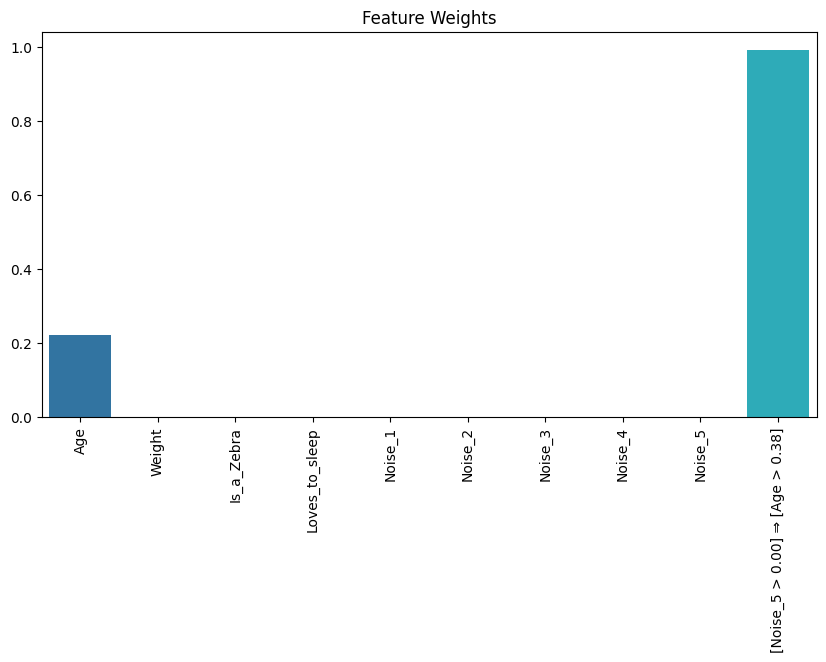

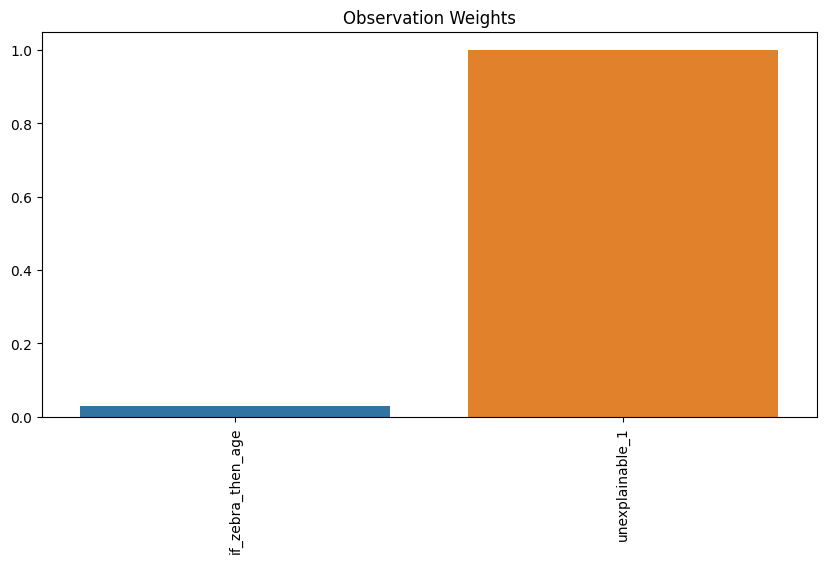

In [1620]:
model.plot(0.05)

In [1130]:
model.interpretation(0, 0.05)

'[Loves_to_sleep > 0.00] ∧ [Noise_3 > 0.00] ∧ [Noise_4 > 0.00] ∧ [Noise_5 > 0.00] ⇒ [Age > 0.36]'

In [ ]:
feature_dict, observation_dict = model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if True: #v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

In [ ]:
remaining_features, remaining_observations

In [ ]:
next_model = FeatureSelectionModel(
    df_explainable,
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

# After this many steps, the learning rate is halved
HALFLIFE = 50

optimizer = torch.optim.RMSprop(lr=0.1, momentum=0.50, params=next_model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = next_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {next_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

In [ ]:
def logic_string_helper(self, _weights, positions, thresh):
    _features_indices = (_weights > thresh).nonzero()[0]
    if len(_features_indices) > 0:
        _features = self.feature_names[_features_indices]
        _position = positions[_features_indices]
        _string = ''
        i = 0
        for symbol, pos in zip(_features, _position):
            if pos < 0.5:
                addendum = 'Higher('
            else:
                addendum = 'Lower('
            if i == len(_features) - 1:
                _string += f'{addendum}{symbol})'
            else:
                _string += f'{addendum}{symbol}) ∧ '
            i += 1
    else:
        _string = 'Falsum'
    return _string

def interpretation(self, v_i, thresh = 0.05):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
        consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
        antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

        antecedens_weights = antecedens_weights/antecedens_weights.sum()
        consequent_weights = consequent_weights/consequent_weights.sum()

        antecedens_string = logic_string_helper(self, antecedens_weights, antecedens_positions, thresh)
        consequent_string = logic_string_helper(self, consequent_weights, consequent_positions, thresh)
        interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

        return interpretation_string

In [ ]:
self = next_model

In [ ]:
interpretation(self, 0)

In [ ]:
thresh = 0.05

In [ ]:
antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()

In [ ]:
antecedens_weights = antecedens_weights/antecedens_weights.sum()
consequent_weights = consequent_weights/consequent_weights.sum()

In [ ]:
antecedens_features_indices = (antecedens_weights > thresh).nonzero()[0]
if len(antecedens_features_indices) > 0:
    antecedens_features = self.feature_names[antecedens_features_indices]
    antecedens_position = antecedens_positions[antecedens_features_indices]
    antecedens_string = ''
    i = 0
    for symbol, pos in zip(antecedens_features, antecedens_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(antecedens_features) - 1:
            antecedens_string += f'{addendum}{symbol})'
        else:
            antecedens_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    antecedens_string = 'Falsum'

In [ ]:
consequent_features_indices = (consequent_weights > thresh).nonzero()[0]
if len(consequent_features_indices) > 0:
    consequent_features = self.feature_names[consequent_features_indices]
    consequent_position = consequent_positions[consequent_features_indices]
    consequent_string = ''
    i = 0
    for symbol, pos in zip(consequent_features, consequent_position):
        if pos < 0.5:
            addendum = 'Higher('
        else:
            addendum = 'Lower('
        if i == len(consequent_features) - 1:
            consequent_string += f'{addendum}{symbol})'
        else:
            consequent_string += f'{addendum}{symbol}) ∧ '
        i += 1
else:
    consequent_string = 'Falsum'

In [ ]:
f'{antecedens_string} ⇒ {consequent_string}'

In [ ]:
antecedens_string = [antecedens_features]

In [ ]:
sns.barplot(antecedens_positions)

In [ ]:
sns.barplot(antecedens_weights)

In [ ]:
sns.barplot(consequent_positions)

In [ ]:
sns.barplot(consequent_weights)

In [ ]:
next_model.conditional(0)

In [ ]:
next_model.plot()

In [ ]:
feature_dict, observation_dict = next_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    #if v < 0.500:
    if True:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

In [ ]:
next2_model = FeatureSelectionModel(
    df_explainable,#.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    num_virtual_features=1,
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next2_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 100, timeout=60000)

In [ ]:
next2_model.plot()

In [ ]:
feature_dict, observation_dict = next2_model.get_weights()

remaining_features = []
for k,v in feature_dict.items():
    if v < 0.500:
        remaining_features.append(k)

i = 0
remaining_observations = [index_name]
remaining_observation_indices = []
for k,v in observation_dict.items():
    if v < 0.500:
        remaining_observations.append(k)
        remaining_observation_indices.append(i)
    i += 1

remaining_features, remaining_observations

In [ ]:
next3_model = FeatureSelectionModel(
    df_explainable.loc[:, remaining_features],
    df_observable.loc[:, remaining_observations],
    model.best_cluster_positions[:, remaining_observation_indices],
    power = 4,
    index_name = 'Individual',
    num_samples = 4,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0
)

my_model = next3_model

# After this many steps, the learning rate is halved
HALFLIFE = 30

optimizer = torch.optim.RMSprop(
    params = [
        {'params': my_model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': my_model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = my_model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {my_model.loss().clone().detach()}')
trainer.train(epochs = 10, timeout=60000)

In [ ]:
next3_model.plot()

In [ ]:
...